# KAIST AI605 Assignment 1: Text Classification
TA in charge: Miyoung Ko (miyoungko@kaist.ac.kr)

**Due Date:** March 31 (Thu) 11:00pm, 2022

## Your Submission
If you are a KAIST student, you will submit your assignment via [KLMS](https://klms.kaist.ac.kr). If you are a NAVER student, you will submit via [Google Form](https://forms.gle/qjjkqazLvA7tkfUz7). 

You need to submit both (1) a PDF of this notebook, and (2) a link to CoLab for execution (.ipynb file is also allowed).

Use in-line LaTeX (see below) for mathematical expressions. Collaboration among students is allowed but it is not a group assignment so make sure your answer and code are your own. Make sure to mention your collaborators in your assignment with their names and their student ids.

## Grading
The entire assignment is out of 20 points. You can obtain up to 2 bonus points (i.e. max score is 22 points). For every late day, your grade will be deducted by 2 points (KAIST students only). You can use one of your no-penalty late days (7 days in total). Make sure to mention this in your submission. You will receive a grade of zero if you submit after 7 days.


## Environment
You will need Python 3.7+ and PyTorch 1.9+, which are already available on Colab:

In [1]:
from platform import python_version
import torch
from torch import nn
from torchsummary import summary
import numpy as np 
import matplotlib.pyplot as plt

print("python", python_version())
print("torch", torch.__version__)

python 3.9.7
torch 1.11.0+cpu


In [2]:
!pip install torchsummary

## 1. Limitations of Vanilla RNNs
In Lecture 02, we saw that a multi-layer perceptron (MLP) without activation function is equivalent to a single linear transformation with respect to the inputs. One can define a vanilla recurrent neural network without activation as, given inputs $\textbf{x}_1 \dots \textbf{x}_T$, the outputs $\textbf{h}_t$ is obtained by
$$\textbf{h}_t = \textbf{V}\textbf{h}_{t-1} + \textbf{U}\textbf{x}_t + \textbf{b},$$
where $\textbf{V}, \textbf{U}, \textbf{b}$ are trainable weights. 

> **Problem 1.1** *(2 point)* Show that such recurrent neural network (RNN) without activation function is equivalent to a single linear transformation with respect to the inputs, which means each $\textbf{h}_t$ is a linear combination of the inputs.

**Answer** 
>First of all lets wright the firts hidden functions for $t$ = {1 , 2, 3} : 
\begin

\begin{equation}
    \left\lbrace
		\begin{split}
            h_1 &= Ux_1 + b \\
            \\
            h_2 &= Vh_1 + Ux_2 + b \\
                &= UVx_1 + Ux_2 + b(V+1)\\
            \\
            h_3 &= Vh_2 + Ux_3 +b = V[UVx_1 + Ux_2 + b(V+1)] +  Ux_3 +b \\
                &= U[ V²x_1 + Vx_2 + x_3] + b[V²+V+1] 
		\end{split}
	\right.
\end{equation}

>We deduced the recurrent expression : 
$$h_n = U \sum\limits_{i=1}^{n} V^{n-i}x_i + b\sum\limits_{i=1}^{n} V^{i-1}$$
We are going to prove the previous statement with an induction method. 
>
>
>**Base case**: for $n=0$ the expression is obviously true. 
>
>
>**Inductive step:**  Show that for any $n$ ≥ $0$, if the statement holds for the rank $n$, then it also holds for $n+1$. 
>
>
>We assume the induction hypothesis that for a particular $n$, the single case for the rank $n$ holds, meaning the statement for $n$ is true. So 
$$h_n = U \sum\limits_{i=1}^{n} V^{n-i}x_i + b\sum\limits_{i=1}^{n} V^{i-1}$$
and 
$$ h_{n+1} = Vh_{n} + Ux_{n+1} + b $$ so, it follows that  
$$ h_{n+1} = V[U \sum\limits_{i=1}^{n} V^{n-i}x_i + b\sum\limits_{i=1}^{n} V^{i-1}] + Ux_{n+1} + b $$ 
$$ h_{n+1} = U [\sum\limits_{i=1}^{n} V^{n+1-i}x_i  + V^{n+1-(n+1)} x_{n+1}] + b[ \sum\limits_{i=1}^{n} V^{i} + V^0]  $$ buy changing the indexes cleverly in the second sum $(i = j-1)$ We finally obtain : 
$$ h_{n+1} = U [\sum\limits_{i=1}^{n+1} V^{n+1-i}x_i] + b[ \sum\limits_{j=1}^{n+1} V^{j} ] $$
**Conclusion:**  Since both the base case and the inductive step have been proved as true, by mathematical induction the statement holds for every natural number n : 
>
>**Without an activation function, each  $𝐡_t$  is a linear combination of the inputs.**


_______________________________________________________________


In Lecture 05 and 06, we will see how RNNs can model non-linearity via activation function, but they still suffer from exploding or vanishing gradients. We can mathematically show that, if the recurrent relation is
$$ \textbf{h}_t = \sigma (\textbf{V}\textbf{h}_{t-1} + \textbf{U}\textbf{x}_t + \textbf{b}) $$
then
$$ \frac{\partial \textbf{h}_t}{\partial \textbf{h}_{t-1}} = \text{diag}(\sigma' (\textbf{V}\textbf{h}_{t-1} + \textbf{U}\textbf{x}_t + \textbf{b}))\textbf{V}$$
so
$$\frac{\partial \textbf{h}_T}{\partial \textbf{h}_1} \propto \textbf{V}^{T-1}$$
which means this term will be very close to zero if the norm of $\bf{V}$ is smaller than 1 and really big otherwise.

> **Problem 1.2** *(2 points)* Explain how exploding gradient can be mitigated if we use gradient clipping.

>**Answer** \

>There are several ways to avoid an exploding gradient. A  common way is the $\mathcal{L}_2$ regulation approach, which is based on a "weight decay" of the cost function of the network. But there is also the **gradient Clipping** which has better results and is easier to implement. The gradient clipping is used during the backward propagation phase. The error derivative is changed or clipped to a threshold, and the clipped gradient updates weights.
>
>When the error is rescaled, it will also rescale the weight during their updates. In this way the risk of overflow or underflow of the network. They are two ways to "clip the gradient".The first one is clipping by value: here we have two boundary values,  if the gradient is not between them it is clipped and receives the threshold value.
>
>The second method is clipping by norm, if the norm of the gradient exceeds a threshold value, then $$gradient= threshold.\frac{gradient}{||gradient||} $$ Like the gradient, the maximum norm a gradient can achieve is the threshold. So it avoids exploding gradient.
>
> At the end we have $\forall t$ 
\begin{equation}
    g_t = 
    \left\lbrace
		\begin{split}
            \lambda \frac{g_t}{||g_t||} \text{  if  } ||g_t|| > \lambda\\\
            g_t \text{    otherwise}
		\end{split}
	\right.
\end{equation}
> So This avoids the scenario where $g_t \longrightarrow \infty$ and so the exploding gradient. 
_____________________________________________________________________

> **Problem 1.3** *(2 points)* Explain how vanishing gradient can be mitigated if we use LSTM. See the Lecture 05 and 06 slides for the definition of LSTM.

> The vanishing gradient, means that the gradient becomes too small and doesn't change at each iterations. The LSTM method uses different "gates" which appear in the expression of the gradient. There is a gate called forget gates, the forget gate's vector of activation helps the model do decide whether or not the value should be forgotten. To avoid the vanishing gradient, we just have to choose the parameter of the gates such as in the next step we don't have $ \nabla \longrightarrow 0$ 
Mathematicaly we can see it with the expretion of the output of an LSTM cell: 
$$ c_t = f_t * c_{t-1} + i_t * \widetilde{c_t}  (1)$$
Where * represent the Hadamard product. We compute the gradient of the expression (1) with respect to $c_1$
>
>\begin{equation}
		\begin{split}
            g_t & =  \frac{\partial \textbf{c}_t}{\partial \textbf{c}_1} \\
                &= \frac{\partial \textbf{c}_t}{\partial \textbf{c}_{t-1}} \cdot \frac{\partial \textbf{c}_{t-1}}{\partial \textbf{c}_{t-2}} \cdots \frac{\partial \textbf{c}_2}{\partial \textbf{c}_{1}} \text{   (chain rule)} \\
		\end{split}
\end{equation}
>
>But, $ i_t * \widetilde{c_t}$ and $f_t$ are independant of $c_t, \forall t $. So $\forall i \in [[ 1, t]]$ : 
>
>\begin{equation}
		\begin{split}
            \frac{\partial }{\partial \textbf{c}_i} (i_{i+1} * \widetilde{c_{i+1}}) &=0  \\
            \frac{\partial }{\partial \textbf{c}_i} (f_{i+1} * c_{i}) &= f_{i+1} \\
		\end{split}
\end{equation}
>
>Hense
>
>\begin{equation}
		\begin{split}
            g_t &=f_t . f_{t-1} ... f_{2}  \text{           ( 2 )}  \\
		\end{split}
\end{equation}
>
> Here $f_t = \sigma_g (W_fx_f + U_f +b_f)$ where $\sigma_g$ is the sigmoide fonction. So, $\forall i \in [[2, t]], f_i \in [0, 1]$. So for each iterations, the gradient will remain close to 1. So as the equation (2) shows, the gradient of the LSTM correspond to the product of the vectors $f_i$, and so cannot vanish. On the other hand, the gradient of the RNN is proportionnal to V so if V is to slow, after only a few iteration it vanishes exponentially.  

## 2. Creating Vocabulary from Training Data
Creating the vocabulary is the first step for every natural language processing model. In this section, you will use Stanford Sentiment Treebank (SST), a popular dataset for sentiment classification, to create your vocabulary.

### Obtaining SST via Hugging Face
We will use `datasets` package offered by Hugging Face, which allows us to easily download various language datasets, including Stanford Sentiment Treebank.

First, install the package:

!pip install datasets

Then download SST and print the first example:

In [3]:
from datasets import load_dataset
from pprint import pprint

sst_dataset = load_dataset('sst')
pprint(sst_dataset['train'][0])

No config specified, defaulting to: sst/default
Reusing dataset sst (C:\Users\Utilisateur\.cache\huggingface\datasets\sst\default\1.0.0\b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


  0%|          | 0/3 [00:00<?, ?it/s]

{'label': 0.6944400072097778,
 'sentence': "The Rock is destined to be the 21st Century 's new `` Conan '' "
             "and that he 's going to make a splash even greater than Arnold "
             'Schwarzenegger , Jean-Claud Van Damme or Steven Segal .',
 'tokens': "The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.",
 'tree': '70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|67|68|69|71|71|0'}


In [4]:
pprint(sst_dataset)

{'test': Dataset({
    features: ['sentence', 'label', 'tokens', 'tree'],
    num_rows: 2210
}),
 'train': Dataset({
    features: ['sentence', 'label', 'tokens', 'tree'],
    num_rows: 8544
}),
 'validation': Dataset({
    features: ['sentence', 'label', 'tokens', 'tree'],
    num_rows: 1101
})}


Note that each `label` is a score between 0 and 1. You will round it to either 0 or 1 for binary classification (positive for 1, negative for 0).
In this first example, the label is rounded to 1, meaning that the sentence is a positive review.
You will only use `sentence` as the input; please ignore other values.

> **Problem 2.1** *(2 points)* Using space tokenizer, create the vocabulary for the training data and report the vocabulary size here. Make sure that you add an `UNK` token to the vocabulary to account for words (during inference time) that you haven't seen. See below for an example with a short text.

In [5]:
# contructing the vocabulary of the dataset 
vobab_dataset = ['PAD', 'UNK']
           
for i in range (0, len(sst_dataset['train'])):
    # we can either chose to put every words in lower case or not, here we chose to put it in lower case
    
    vobab_dataset= (vobab_dataset+ sst_dataset['train'][i]['sentence'].lower().split(' '))
    #vobab_dataset= (vobab_dataset+ sst_dataset['train'][i]['sentence'].split(' '))

word_id = {word: id_ for id_, word in enumerate(vobab_dataset)}

In [6]:
print(len(vobab_dataset))

163565


pprint(vobab_dataset)

> **Problem 2.2** *(1 point)* Using all words in the training data will make the vocabulary very big. Reduce its size by only including words that occur at least 2 times. How does the size of the vocabulary change?

In [8]:
freq_threshold = 2
frequencies = {}
# We initialise PAD to 0 and UNK to 1
light_vocab = ['PAD','UNK']
light_wordIndx = {'PAD': 0 ,'UNK': 1}
idx = 2
for word in vobab_dataset: 
    if word.isalpha(): 
        if word not in frequencies: 
            frequencies[word] = 1
        else : 
            frequencies[word] +=1
        if frequencies[word]== freq_threshold: 
            light_vocab.append(word)
            light_wordIndx[word]= idx
            idx+= 1


In [9]:
# with the upper case word we get len(light_vocab) = 8738
# with all the caracter wich are not letters (ie without isalpaha check ) len(light_vocab) = 8218
print(len(light_vocab))

7810


#The dictionnary
pprint(light_wordIndx)

output : 
{'PAD': 0,
 'UNK': 1,
 'a': 7,
 'aaliyah': 7475,
 'abandon': 3017,
 'abandoned': 7185,
 'abc': 7397,
 'abel': 5558,
 'abhorrent': 6529,
 'ability': 1127,
 'able': 997,
 'ably': 2808,
 'abound': 4127,
 'about': 130,

## 3. Text Classification with Multi-Layer Perceptron and Recurrent Neural Network

You can now use the vocabulary constructed from the training data to create an embedding matrix. You will use the embedding matrix to map each input sequence of tokens to a list of embedding vectors. One of the simplest baseline is to fix the input length (with truncation or padding), flatten the word embeddings, apply a linear transformation followed by an activation, and finally classify the output into the two classes: 

In [11]:
# parameters 

padding = 32
length = 32
weight_decay=7e-4
learning_rate=0.01
batch_size = 128 #BEFORE (50)
epochs = 100
d = 64 # before 3 and 128  

In [12]:
# Two-layer MLP classification
class Baseline(nn.Module):
    def __init__(self, d, length, vocab= light_vocab):
        super(Baseline, self).__init__()
        self.embedding = nn.Embedding(len(vocab), d)
        self.layer = nn.Linear(d * length, d, bias=True)
        self.relu  = nn.ReLU()
        self.class_layer = nn.Linear(d, 2, bias=True)

    def forward(self, input_tensor):
        emb = self.embedding(input_tensor) # [batch_size, length, d]
        emb_flat = emb.view(emb.size(0), -1) # [batch_size, length*d]
        hidden = self.relu(self.layer(emb_flat))
        logits = self.class_layer(hidden)
        return logits

Now we will compute the loss, which is the negative log probability of the input text's label being the target label (`1`), which in fact turns out to be equivalent to the cross entropy (https://en.wikipedia.org/wiki/Cross_entropy) between the probability distribution and a one-hot distribution of the target label (note that we use `logits` instead of `softmax(logits)` as the input to the cross entropy, which allow us to avoid numerical instability). 

Once we have the loss defined, only one step remains! We compute the gradients of parameters with respective to the loss and update. Fortunately, PyTorch does this for us in a very convenient way. Note that we used only one example to update the model, which is basically a Stochastic Gradient Descent (SGD) with minibatch size of 1. A recommended minibatch size in this exercise is at least 16. It is also recommended that you reuse your training data at least 10 times (i.e. 10 *epochs*).

Once you have done this, all weight parameters will have `grad` attributes that contain their gradients with respect to the loss.

================================================================================================

> **Problem 3.1** *(2 points)* Properly train a MLP baseline model on SST and report the model's accuracy on the dev data.

### Contruction of the embedded matrix : 

In [13]:
def vector_contructor(sentence, light_vocab= light_vocab,
                      light_wordIndx = light_wordIndx, padding= padding):  
    sentence_tocken = sentence.split(' ')
    sentence_ids = [light_wordIndx[word] if word in light_wordIndx 
                    else 1 for word in sentence_tocken] # UNK if word not found
    if len(sentence_ids)<padding: 
        sentence_ids = sentence_ids + [0] * (padding - len(sentence_ids)) # PAD tokens at the end
    else:
        sentence_ids = sentence_ids[:padding]

    return(torch.LongTensor([sentence_ids]))

### TRAINING SET 

In [14]:
## we construct the input tensor of the SST 

input_tensor = torch.zeros(1,padding)
for i in range (0, len(sst_dataset['train'])):
    input_tensor = torch.cat([input_tensor, vector_contructor( sst_dataset['train'][i]['sentence'])]) 
input_tensor = input_tensor[1:,:].long()

print(vector_contructor (sst_dataset['train'][0]['sentence']))
print(input_tensor[0])

tensor([[   1,    1,    5, 1983,    3,   24,    2,    1,    1,    1,   51,    1,
            1,    1,   13,    6,   97,    1,  127,    3,   25,    7, 5969,   38,
         1001,   18,    1,    1,    1,    1,    1,    1]])
tensor([   1,    1,    5, 1983,    3,   24,    2,    1,    1,    1,   51,    1,
           1,    1,   13,    6,   97,    1,  127,    3,   25,    7, 5969,   38,
        1001,   18,    1,    1,    1,    1,    1,    1])


Two exemples :  

In [15]:
# test : 
print(vector_contructor('It was a really good movie'))
# more than eight words 
print(vector_contructor('I lived at KAIST for at least a dozen of weeks now'))

tensor([[  1,  81,   7, 128,  19,  63,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0]])
tensor([[   1,  601,   29,    1,   31,   29,  822,    7, 7157,    4, 1975,  139,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0]])


### TESTING SET

In [16]:
## input tensor for the test set 

input_tensor_test = torch.zeros(1,padding)
for i in range (0, len(sst_dataset['test'])):
    input_tensor_test = torch.cat([input_tensor_test, vector_contructor( sst_dataset['test'][i]['sentence'])]) 
input_tensor_test = input_tensor_test[1:,:].long()

print (input_tensor_test)
print(input_tensor_test.size())

tensor([[   1,   45,    1,  ...,    0,    0,    0],
        [   1,   11,   94,  ...,    0,    0,    0],
        [   1,   33,  622,  ...,    0,    0,    0],
        ...,
        [   1,    1,    1,  ...,    0,    0,    0],
        [   1,    1, 5324,  ...,    0,    0,    0],
        [   1,    1,    1,  ...,    0,    0,    0]])
torch.Size([2210, 32])


### GROUND TRUTH

We construct a vector for the ground truth (1= Positive , 0 = Negative)

In [17]:
ground_truth = [int(round(sst_dataset['train'][i]['label'])) for i in range (0, len(sst_dataset['train']))]
ground_truth = (torch.LongTensor(ground_truth))

ground_truth_test = [int(round(sst_dataset['test'][i]['label'])) for i in range (0, len(sst_dataset['test']))]
ground_truth_test = (torch.LongTensor(ground_truth_test))

### Construction of the model

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [19]:
# method to shuffle a the imput and its index
def permutation(x, y) : 
    mat = torch.cat((x, y), 1)
    r = torch.randperm(mat.size()[0])
    mat=mat[r]
    return mat[:,:-1], mat[:,-1]

In [20]:
def trainer (model, input_tensor= input_tensor, input_tensor_test = input_tensor_test, 
             optimizer = 'SGD', weight_decay= weight_decay,
             learning_rate = learning_rate , epochs = epochs,
             print_ = True):
    
    if optimizer =='SGD': 
        optimizer = torch.optim.SGD (model.parameters(), lr=learning_rate, weight_decay= weight_decay )
    if optimizer =='Adam': 
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay= weight_decay)
    
    
    accuracy_list_test  = []
    accuracy_list_train = []
    epochs_list         = []
    result_final_best   = 0
    
    epoch_5, accuracy_train_5 , accuracy_test_5 =[], [], []
    
    for epoch in range (0, epochs+1) : 
        permutation = torch.randperm(input_tensor.size()[0])
        permutation_test = torch.randperm(input_tensor_test.size()[0])
    
        ###Training###
    
        moved_loss= None
    
        model.train()

        for i in range (0, input_tensor.size()[0], batch_size): 
            optimizer.zero_grad() # reset process
        
            index  = permutation[i:i+batch_size] # mixt the input index
           
            X       = input_tensor[index]  # input of the model of the batch sized
            Y_model = model(X)     # result of the model 
            Y_true  = ground_truth[index]  # ground truth 
           
            loss = cel(Y_model, Y_true)
            #moved_loss = (loss.detach() if moved_loss is None else 
            #         0.2*moved_loss + 0.8*loss.detach())
        
            #optimizer.zero_grad() # reset process
            loss.backward() # compute gradients
            optimizer.step() # update parameters
  

        ###Testing of the performance###
        with torch.no_grad():
            model.eval()
            correct_train = 0
            result_train  = 0 
        
            for j in range (0, input_tensor.size()[0], batch_size): 
                
                index   = permutation[j:j+batch_size]

                X_train       = input_tensor[index]
            
                Y_model_train = model(X_train)
                # We get the colomn with the biggest probability 
                Y_model_train_result = torch.argmax(Y_model_train, dim=1)
            
                Y_true_train   = ground_truth[index]
            
                correct_train += torch.sum(Y_model_train_result == Y_true_train).item()
                result_train  += len(Y_true_train)
        
            result_train_final =  correct_train*100/result_train
       
        with torch.no_grad():
            model.eval()
            correct_test = 0 
            result_test  = 0 
        
            for k in range (0, input_tensor_test.size()[0], batch_size): 

                index_test   = permutation_test[k:k+batch_size]

                
                X_test       = input_tensor_test[index_test]
                Y_model_test = model(X_test)
                # We get the colomn with the biggest probability 
                Y_model_test_result = torch.argmax(Y_model_test, dim=1)
            
                Y_true_test  = ground_truth_test[index_test]
                correct_test += torch.sum(Y_model_test_result == Y_true_test).item()
                result_test  += len(Y_true_test)
            
            result_test_final =  correct_test*100/result_test
        result_final_best = max(result_test_final, result_final_best)        
        accuracy_list_test.append(result_test_final)
        accuracy_list_train.append(result_train_final) 
        epochs_list.append(epoch)
    
    
        if epoch%10 == 0 and print_ == True : 
                print("===============================================")         
                print(f"Epoch {epoch}\n-------------------------------")
                print("loss training set", loss,  '\n', "Train accuracy", result_train_final, 
                  '\n', "Test accuracy", result_test_final)   
        if epoch%5 == 0 and print_ == False: 
                epoch_5.append(epoch)
                accuracy_train_5.append(result_train_final)
                accuracy_test_5.append(result_test_final)
    if print_ == True : 
        print("===============================================", '\n')         
        print("best accuracy test", result_final_best)
    else : 
        return (epoch_5, accuracy_train_5 , accuracy_test_5)

    

In [21]:
cel = nn.CrossEntropyLoss()
label = ground_truth 

### Research of the parameter for SGD optimizer

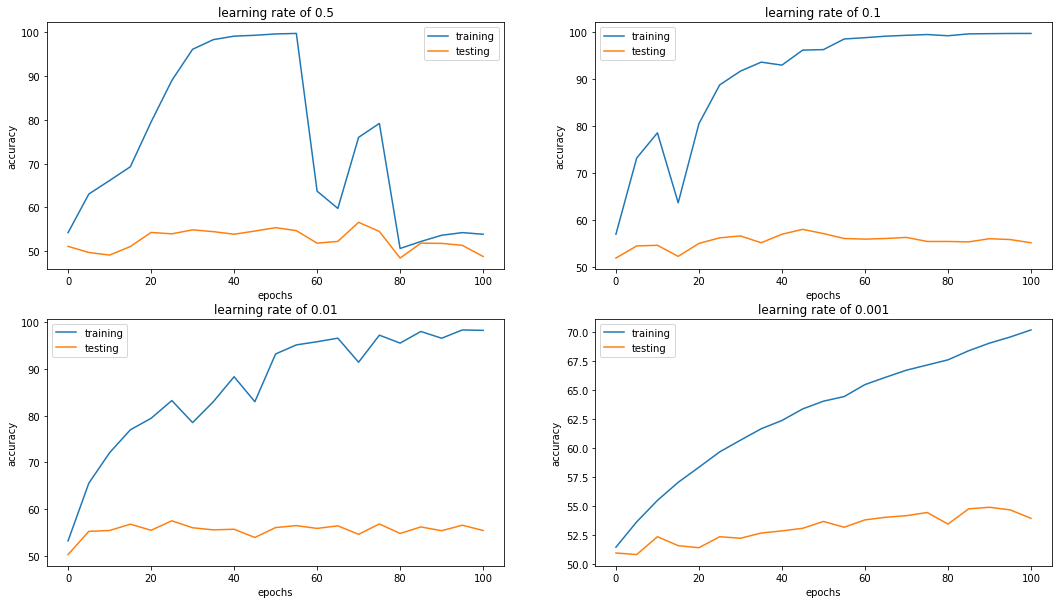

In [22]:
## Searching of the best parametters : LEARNING RATE 

baseline1 = Baseline(d, padding)
baseline2 = Baseline(d, padding)
baseline3 = Baseline(d, padding)
baseline4 = Baseline(d, padding)

#SGD
x1, y1, yt1 =trainer (baseline1, learning_rate = 0.5 ,  print_ = False)
x2, y2, yt2 =trainer (baseline2, learning_rate = 0.1 ,  print_ = False)
x3, y3, yt3 =trainer (baseline3, learning_rate = 0.01 , print_ = False)
x4, y4, yt4 =trainer (baseline4, learning_rate = 0.001, print_ = False)
    

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

ax[0,0].plot(x1, y1, label='training')
ax[0,0].plot(x1, yt1, label='testing')
ax[0,0].set_xlabel('epochs')
ax[0,0].set_ylabel('accuracy')
ax[0,0].set_title('learning rate of 0.5')
ax[0,0].legend()

ax[0,1].plot(x2, y2, label='training')
ax[0,1].plot(x2, yt2, label='testing')
ax[0,1].set_xlabel('epochs')
ax[0,1].set_ylabel('accuracy')
ax[0,1].set_title('learning rate of 0.1')
ax[0,1].legend()

ax[1,0].plot(x3, y3, label='training')
ax[1,0].plot(x3, yt3, label='testing')
ax[1,0].set_xlabel('epochs')
ax[1,0].set_ylabel('accuracy')
ax[1,0].set_title('learning rate of 0.01')
ax[1,0].legend()

ax[1,1].plot(x4, y4, label='training')
ax[1,1].plot(x4, yt4, label='testing')
ax[1,1].set_xlabel('epochs')
ax[1,1].set_ylabel('accuracy')
ax[1,1].set_title('learning rate of 0.001')
ax[1,1].legend()

plt.show()

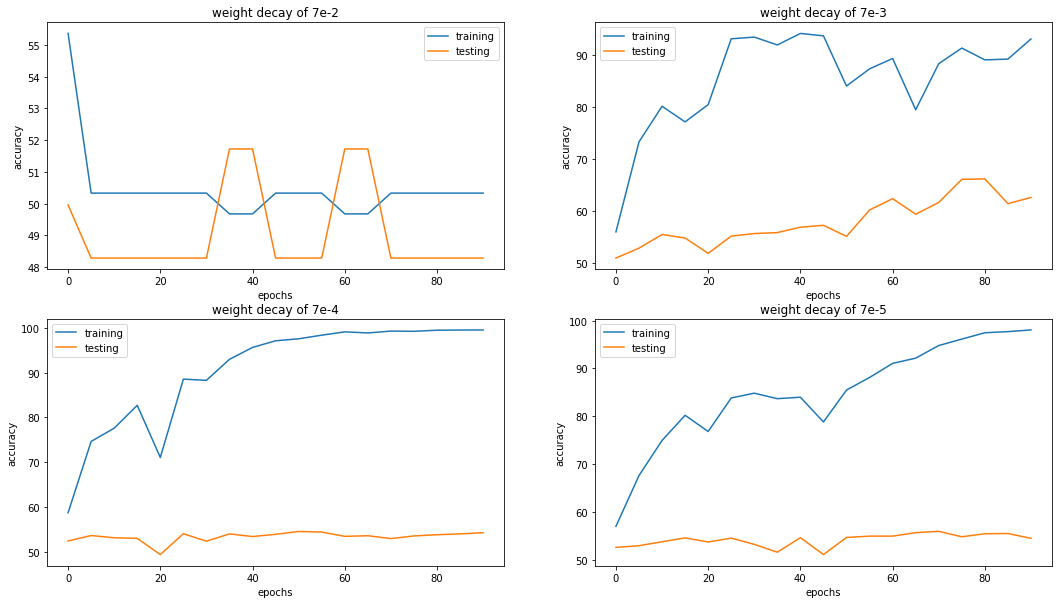

In [23]:
## Searching of the best parametters : WEIGHT DECAY 

baseline1 = Baseline(d, padding)
baseline2 = Baseline(d, padding)
baseline3 = Baseline(d, padding)
baseline4 = Baseline(d, padding)

#SGD
x1, y1, yt1 =trainer (baseline1, weight_decay = 7e-2 ,learning_rate = 0.1 , epochs = 90, print_ = False)
x2, y2, yt2 =trainer (baseline2, weight_decay = 7e-3 ,learning_rate = 0.1 , epochs = 90, print_ = False)
x3, y3, yt3 =trainer (baseline3, weight_decay = 7e-4 ,learning_rate = 0.1 , epochs = 90, print_ = False)
x4, y4, yt4 =trainer (baseline4, weight_decay = 7e-5 ,learning_rate = 0.1 , epochs = 90, print_ = False)
    

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

ax[0,0].plot(x1, y1, label='training')
ax[0,0].plot(x1, yt1, label='testing')
ax[0,0].set_xlabel('epochs')
ax[0,0].set_ylabel('accuracy')
ax[0,0].set_title('weight decay of 7e-2')
ax[0,0].legend()

ax[0,1].plot(x2, y2, label='training')
ax[0,1].plot(x2, yt2, label='testing')
ax[0,1].set_xlabel('epochs')
ax[0,1].set_ylabel('accuracy')
ax[0,1].set_title('weight decay of 7e-3')
ax[0,1].legend()

ax[1,0].plot(x3, y3, label='training')
ax[1,0].plot(x3, yt3, label='testing')
ax[1,0].set_xlabel('epochs')
ax[1,0].set_ylabel('accuracy')
ax[1,0].set_title('weight decay of 7e-4')
ax[1,0].legend()

ax[1,1].plot(x4, y4, label='training')
ax[1,1].plot(x4, yt4, label='testing')
ax[1,1].set_xlabel('epochs')
ax[1,1].set_ylabel('accuracy')
ax[1,1].set_title('weight decay of 7e-5')
ax[1,1].legend()

plt.show()

### Research of the parameter for ADAM optimizer

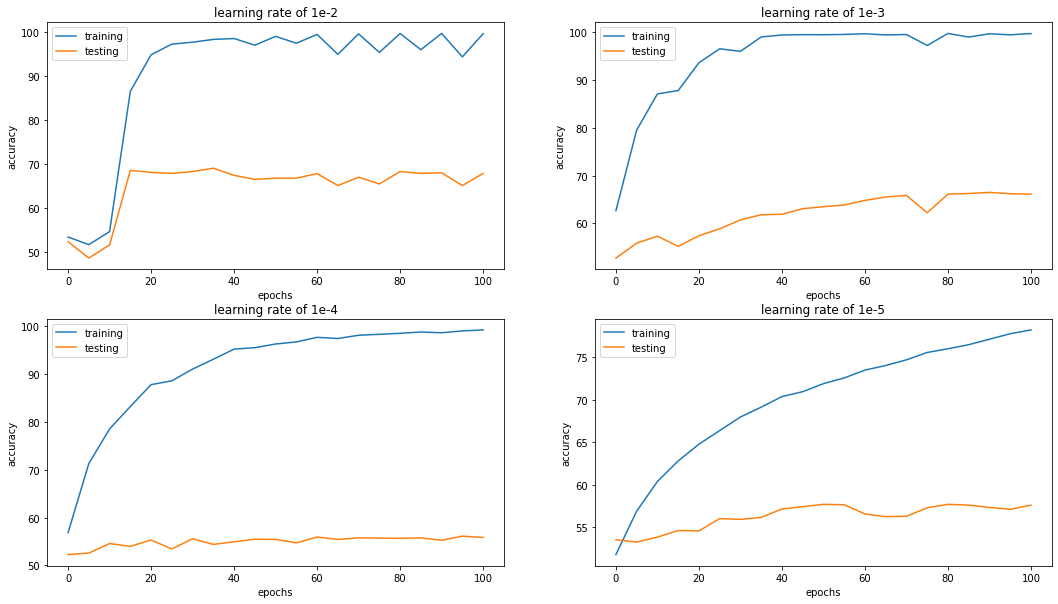

In [24]:
## Searching of the best parametters : LEARNING RATE
x = np.linspace(0.0, 10.0, 1000)
y = np.sin(x)
baseline1 = Baseline(d, padding)
baseline2 = Baseline(d, padding)
baseline3 = Baseline(d, padding)
baseline4 = Baseline(d, padding)

#SGD
x1, y1, yt1 =trainer (baseline1, optimizer = 'Adam', learning_rate = 1e-2 ,  print_ = False)
x2, y2, yt2 =trainer (baseline2, optimizer = 'Adam', learning_rate = 1e-3,  print_ = False)
x3, y3, yt3 =trainer (baseline3, optimizer = 'Adam', learning_rate = 1e-4 , print_ = False)
x4, y4, yt4 =trainer (baseline4, optimizer = 'Adam', learning_rate = 1e-5, print_ = False)
    

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

ax[0,0].plot(x1, y1, label='training')
ax[0,0].plot(x1, yt1, label='testing')
ax[0,0].set_xlabel('epochs')
ax[0,0].set_ylabel('accuracy')
ax[0,0].set_title('learning rate of 1e-2')
ax[0,0].legend()

ax[0,1].plot(x2, y2, label='training')
ax[0,1].plot(x2, yt2, label='testing')
ax[0,1].set_xlabel('epochs')
ax[0,1].set_ylabel('accuracy')
ax[0,1].set_title('learning rate of 1e-3')
ax[0,1].legend()

ax[1,0].plot(x3, y3, label='training')
ax[1,0].plot(x3, yt3, label='testing')
ax[1,0].set_xlabel('epochs')
ax[1,0].set_ylabel('accuracy')
ax[1,0].set_title('learning rate of 1e-4')
ax[1,0].legend()

ax[1,1].plot(x4, y4, label='training')
ax[1,1].plot(x4, yt4, label='testing')
ax[1,1].set_xlabel('epochs')
ax[1,1].set_ylabel('accuracy')
ax[1,1].set_title('learning rate of 1e-5')
ax[1,1].legend()

plt.show()

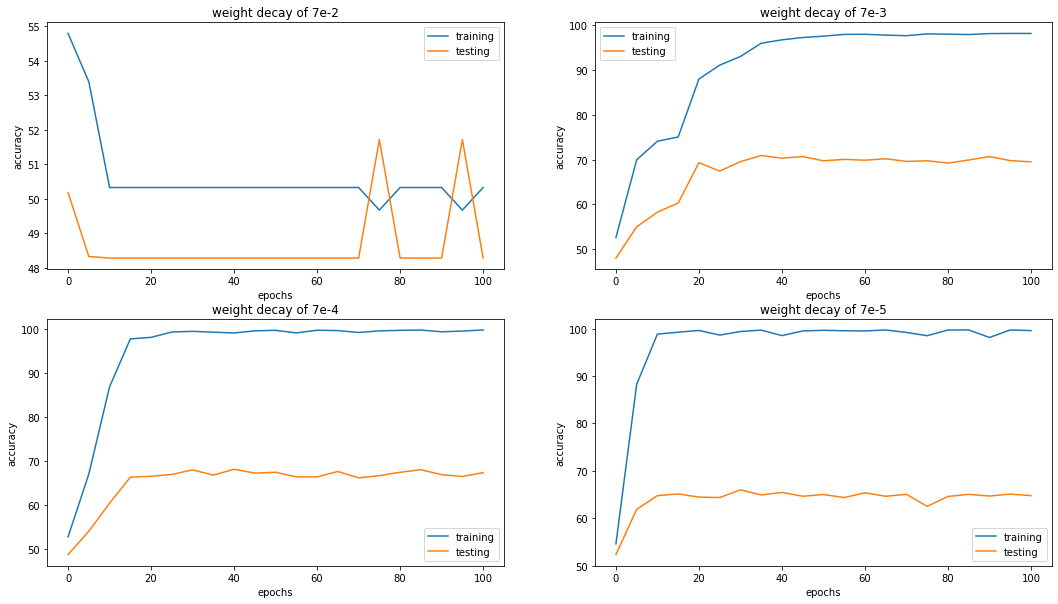

In [25]:
## Searching of the best parametters : WEIGHT DECAY 

baseline1 = Baseline(d, padding)
baseline2 = Baseline(d, padding)
baseline3 = Baseline(d, padding)
baseline4 = Baseline(d, padding)

#SGD
x1, y1, yt1 =trainer (baseline1, optimizer = 'Adam', weight_decay = 7e-2 ,learning_rate = 3e-3 , print_ = False)
x2, y2, yt2 =trainer (baseline2, optimizer = 'Adam', weight_decay = 7e-3 ,learning_rate = 3e-3 , print_ = False)
x3, y3, yt3 =trainer (baseline3, optimizer = 'Adam', weight_decay = 7e-4 ,learning_rate = 3e-3 , print_ = False)
x4, y4, yt4 =trainer (baseline4, optimizer = 'Adam', weight_decay = 7e-5 ,learning_rate = 3e-3 , print_ = False)
    

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

ax[0,0].plot(x1, y1, label='training')
ax[0,0].plot(x1, yt1, label='testing')
ax[0,0].set_xlabel('epochs')
ax[0,0].set_ylabel('accuracy')
ax[0,0].set_title('weight decay of 7e-2')
ax[0,0].legend()

ax[0,1].plot(x2, y2, label='training')
ax[0,1].plot(x2, yt2, label='testing')
ax[0,1].set_xlabel('epochs')
ax[0,1].set_ylabel('accuracy')
ax[0,1].set_title('weight decay of 7e-3')
ax[0,1].legend()

ax[1,0].plot(x3, y3, label='training')
ax[1,0].plot(x3, yt3, label='testing')
ax[1,0].set_xlabel('epochs')
ax[1,0].set_ylabel('accuracy')
ax[1,0].set_title('weight decay of 7e-4')
ax[1,0].legend()

ax[1,1].plot(x4, y4, label='training')
ax[1,1].plot(x4, yt4, label='testing')
ax[1,1].set_xlabel('epochs')
ax[1,1].set_ylabel('accuracy')
ax[1,1].set_title('weight decay of 7e-5')
ax[1,1].legend()

plt.show()

### ADAM VS SGD

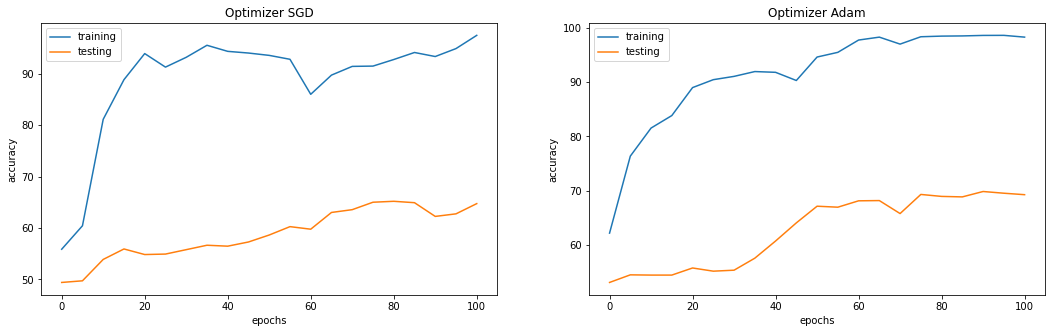

In [26]:
# Comparing to optimizer : SGD vs Adam 

baseline1 = Baseline(d, padding)
baseline2 = Baseline(d, padding)

x1, y1, yt1 =trainer (baseline1, weight_decay = 7e-3 ,learning_rate = 0.1 , print_ = False)
x2, y2, yt2 =trainer (baseline2, optimizer = 'Adam', 
                                 weight_decay = 7e-3 ,learning_rate = 1e-3, print_ = False)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

ax[0].plot(x1, y1, label='training')
ax[0].plot(x1, yt1, label='testing')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('accuracy')
ax[0].set_title('Optimizer SGD')
ax[0].legend()

ax[1].plot(x2, y2, label='training')
ax[1].plot(x2, yt2, label='testing')
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Optimizer Adam')
ax[1].legend()



 So with the appropriate parameters, we have a model which reaches an accuracy between 60 and 70% after 100 epochs with both optimizers. Adam optimizer has slightly better results for the testing set and the training set reach almost 100% of accuracy after 100 epochs. 

# Results : 

In [27]:
# SGD : 
baseline = Baseline(d, padding, light_vocab)
trainer(baseline, input_tensor, weight_decay = 7e-3 ,learning_rate = 0.1)

Epoch 0
-------------------------------
loss training set tensor(0.6960, grad_fn=<NllLossBackward0>) 
 Train accuracy 53.359082397003746 
 Test accuracy 48.8235294117647
Epoch 10
-------------------------------
loss training set tensor(0.4982, grad_fn=<NllLossBackward0>) 
 Train accuracy 78.16011235955057 
 Test accuracy 54.11764705882353
Epoch 20
-------------------------------
loss training set tensor(0.3839, grad_fn=<NllLossBackward0>) 
 Train accuracy 85.59222846441948 
 Test accuracy 54.47963800904977
Epoch 30
-------------------------------
loss training set tensor(0.4391, grad_fn=<NllLossBackward0>) 
 Train accuracy 83.59082397003745 
 Test accuracy 54.11764705882353
Epoch 40
-------------------------------
loss training set tensor(0.3589, grad_fn=<NllLossBackward0>) 
 Train accuracy 91.13998127340824 
 Test accuracy 57.05882352941177
Epoch 50
-------------------------------
loss training set tensor(0.4010, grad_fn=<NllLossBackward0>) 
 Train accuracy 89.45458801498127 
 Test ac

In [28]:
baseline = Baseline(d, padding, light_vocab)
trainer(baseline, input_tensor,optimizer = 'Adam', weight_decay = 7e-3 ,learning_rate = 1e-3)

Epoch 0
-------------------------------
loss training set tensor(0.6918, grad_fn=<NllLossBackward0>) 
 Train accuracy 55.594569288389515 
 Test accuracy 50.723981900452486
Epoch 10
-------------------------------
loss training set tensor(0.5329, grad_fn=<NllLossBackward0>) 
 Train accuracy 79.10814606741573 
 Test accuracy 56.470588235294116
Epoch 20
-------------------------------
loss training set tensor(0.4020, grad_fn=<NllLossBackward0>) 
 Train accuracy 84.45692883895131 
 Test accuracy 57.46606334841629
Epoch 30
-------------------------------
loss training set tensor(0.4018, grad_fn=<NllLossBackward0>) 
 Train accuracy 87.3244382022472 
 Test accuracy 58.8235294117647
Epoch 40
-------------------------------
loss training set tensor(0.4286, grad_fn=<NllLossBackward0>) 
 Train accuracy 84.70271535580524 
 Test accuracy 62.217194570135746
Epoch 50
-------------------------------
loss training set tensor(0.4514, grad_fn=<NllLossBackward0>) 
 Train accuracy 94.05430711610487 
 Test 

> **Problem 3.2** *(2 points)* Implement a recurrent neural network (without using PyTorch's RNN module) with `tanh` activation, and use the output of the RNN at the final time step for the classification. Report the model's accuracy on the dev data.

In [29]:
## A RNN Unit has this equation : ht = tanh ( V*ht-1 + U*xt + b )
## We have to define ;  U : xt  --> U*xt + b
##                      V : ht-1--> V*ht-1

class RNNUnit (nn.Module):
    def __init__(self, input_size, hidden_size): 
        super(RNNUnit, self).__init__()
        self.hidden_size = hidden_size        
        
        #nn.Linear (x_size, y_size) computes xAT + b 
        self.V = nn.Linear(hidden_size, hidden_size , bias = False) # by default bias = True
        self.U = nn.Linear(input_size, hidden_size )  
        self.tanh = nn.Tanh()
        
    def forward (self, h , x) : 
        h = self.tanh( self.V(h) + self.U(x) )  # <=> ht = tanh ( V*ht-1 + U*xt + b )
        return h 

In [30]:

class RNNLayer(nn.Module):
    def __init__(self, rnn_module):
        super(RNNLayer, self).__init__()
        self.rnn_module  = rnn_module
        self.output_size = rnn_module.hidden_size
  
    def forward(self, input_tensor):
        cur_hidden_tensor = torch.zeros(input_tensor.shape[0], self.output_size)
        h_list = []
        for time_step in range(input_tensor.shape[1]):
            cur_input_tensor = input_tensor[:,time_step,: ]
            cur_hidden_tensor = self.rnn_module(cur_hidden_tensor, cur_input_tensor)
            h_list.append(cur_hidden_tensor)
        return torch.stack(h_list, dim=1)


In [31]:
class RNNBaseline(nn.Module):
    def __init__(self, rnn,  d, length, vocab = light_vocab):
        super(RNNBaseline, self).__init__()
        self.rnn   = rnn
        self.embedding = nn.Embedding(len(vocab), d)
        self.layer = nn.Linear(d * length, d, bias=True)
        self.relu  = nn.ReLU()
        self.class_layer = nn.Linear(d, 2, bias=True)

    def forward(self, input_tensor):
        emb = self.embedding(input_tensor) # [batch_size, length, d]
        emb_rnn  = self.rnn.forward(emb)
        emb_flat = emb_rnn.view(emb_rnn.size(0), -1) # [batch_size, length*d]
        hidden = self.relu(self.layer(emb_flat))
        logits = self.class_layer(hidden)        
        return logits

In [32]:
rnn_unit     = RNNUnit( d, d) #hiden dimention 
rnn_layer    = RNNLayer (rnn_unit)
rnn_baseline = RNNBaseline(rnn_layer, d, padding, light_vocab)

### Adam optimizer

In [33]:
trainer(rnn_baseline, input_tensor, optimizer = 'Adam', weight_decay = 7e-4 ,learning_rate = 1e-3)

Epoch 0
-------------------------------
loss training set tensor(0.6979, grad_fn=<NllLossBackward0>) 
 Train accuracy 62.230805243445694 
 Test accuracy 53.93665158371041
Epoch 10
-------------------------------
loss training set tensor(0.1406, grad_fn=<NllLossBackward0>) 
 Train accuracy 97.49531835205993 
 Test accuracy 56.334841628959275
Epoch 20
-------------------------------
loss training set tensor(0.0516, grad_fn=<NllLossBackward0>) 
 Train accuracy 99.46161048689139 
 Test accuracy 57.918552036199095
Epoch 30
-------------------------------
loss training set tensor(0.0304, grad_fn=<NllLossBackward0>) 
 Train accuracy 99.62546816479401 
 Test accuracy 59.457013574660635
Epoch 40
-------------------------------
loss training set tensor(0.0991, grad_fn=<NllLossBackward0>) 
 Train accuracy 98.04541198501873 
 Test accuracy 60.85972850678733
Epoch 50
-------------------------------
loss training set tensor(0.0558, grad_fn=<NllLossBackward0>) 
 Train accuracy 99.12219101123596 
 Tes

## SGD optimier 

In [34]:
rnn_unit2     = RNNUnit( d, d) #hiden dimention 
rnn_layer2    = RNNLayer (rnn_unit)
rnn_baseline2 = RNNBaseline(rnn_layer, d, padding, light_vocab)

trainer(rnn_baseline2, input_tensor, weight_decay = 7e-3 ,learning_rate = 0.1)

Epoch 0
-------------------------------
loss training set tensor(0.6963, grad_fn=<NllLossBackward0>) 
 Train accuracy 53.616573033707866 
 Test accuracy 47.782805429864254
Epoch 10
-------------------------------
loss training set tensor(0.5749, grad_fn=<NllLossBackward0>) 
 Train accuracy 80.12640449438203 
 Test accuracy 54.977375565610856
Epoch 20
-------------------------------
loss training set tensor(0.4407, grad_fn=<NllLossBackward0>) 
 Train accuracy 88.47144194756554 
 Test accuracy 55.339366515837106
Epoch 30
-------------------------------
loss training set tensor(0.4194, grad_fn=<NllLossBackward0>) 
 Train accuracy 88.65870786516854 
 Test accuracy 54.886877828054295
Epoch 40
-------------------------------
loss training set tensor(0.4590, grad_fn=<NllLossBackward0>) 
 Train accuracy 89.8057116104869 
 Test accuracy 57.33031674208145
Epoch 50
-------------------------------
loss training set tensor(0.4327, grad_fn=<NllLossBackward0>) 
 Train accuracy 82.74812734082397 
 Tes

> **Problem 3.3** *(2 points)* Show that the cross entropy computed above is equivalent to the negative log likelihood of the probability distribution.

> We take a discrete pobality distribution, $\displaystyle{X}$ be a discrete random variable with probability mass function $\displaystyle {p}$ depending on a parameter $\displaystyle {\theta }$. 
>Then the function
>
>$$\mathcal {L} (\theta \mid x)=p_{\theta }(x)=P_{\theta }(X=x) = P(X| \theta = x) $$
>
>is the likelihood function, given the outcome $\displaystyle x$ of the random variable $\displaystyle X$.  The likelihood is equal to the probability that a particular outcome $\displaystyle x$ is observed when the true value of the parameter is >$\displaystyle \theta $. 
>
>If we represent the actual observation for N observations with one-hot encoding (i.e., the $j^{th}$ element is 1 and all other elements are 0 when we observe the $j^th$ outcome), then the likelihood of the same single observation can be represented as : 
>$$P(x_1, ... , x_n | \theta) = \prod_{j=1}^N P({x}_{j}|\theta)(\text{ independence of the samples} $$
>
> We put a log on the above equation, and we first added a normalization factor 1/m in front, then we switch the summation from being “over the individual sample” to “over each distinct values of the sample space”. So we got : 
>
>$$ -\frac{1}{m}\sum_{j=1}^m log P(x_j|w) = - \sum_{j=1}^m p(x_i) log P(x_j|w)$$ 
>
> On the other hand, the expression for the cross entropy is , for $f$ and $g$ two probality density fonctions : 
>
>$$ H (p,q) = \sum_{i=1}^N p(x_i) log (\frac{1}{q(x_i)}) = - \sum p(x_i) log(q(x_i))$$
>
>So 
>
>$$ - \sum_{j=1}^m p(x_i) log P(x_j|w) =  - \sum_{j=1}^m p(x_i) log q(x_i)$$ 
>
>In this sense, we have gone back from likelihood to probability. And we see that NNL is the same as cross entropy.


> **Problem 3.4** *(1 points)* Why is it numerically unstable if you compute log on top of softmax?


>The softmax is defined, with  $ n = [[1,N]] \text{ and } x = (x_1, ...,  x_n) \in {R}^n.$
> $$   \sigma(\textbf{x})_n = \frac{e^{x_n}}{\sum_{i=1}^N e^{x_i}} $$
>
>     
> Let $\theta$ is the maximum value of elements in $x$, which means,
$$ \theta = \max_{ i \in [1, N]} x_i. $$
> Then, $x$ can be written as:
>$$
     \begin{align*}
        \begin{split}
         x&= (x_1, ..., x_n) \\
         &= \left(\theta + (x_1 - \theta), ..., \theta + (x_n - \theta)\right).
       \end{split}  
    \end{align*}
$$
> The log of the softmax $x$ can be computed as:
>
>\begin{align*}
   \begin {split}     
        \log(\sigma(x))
         &= \log\left(\frac{e^{x_1}}{\sum_{i=1}^K e^{x_i}}, ..., \frac{e^{x_N}}{\sum_{i=1}^N e^{z_i}}\right) \\
         &= \log\left(\frac{e^{x_1 - \theta}}{\sum_{i=1}^N e^{x_i - \theta}}, ..., \frac{e^{x_N - \theta}}{\sum_{i=1}^N e^{x_i - \theta}}\right) \\
         &= \left(\log\frac{e^{x_1 - \theta}}{\sum_{i=1}^N e^{x_i - \theta}}, ..., \log\frac{e^{x_N - \theta}}{\sum_{i=1}^N e^{x_i - \theta}}\right).
    \end{split}       
\end{align*}
>
> Then we search for $\lambda$, the smaller elements in $x$: 
> $$ \lambda = \min_{ j \in [1, N] } x_j. $$
> Then, as $\lambda - \theta \to -\infty$, $e^{\lambda-\theta} \to 0$ and $\frac{e^{\lambda-\theta}}{\sum_{i=1}^N e^{x_i - \theta}} \to 0$.
> This gives $\log\frac{e^{\lambda-\theta}}{\sum_{i=1}^N e^{x_i - \theta}} \to -\infty$ in the result of the log of the softmax $x$, which makes numerically unstable.

## 4. Text Classification with LSTM and Dropout

Replace your RNN module with an LSTM module. See Lecture slides 05 and 06 for the formal definition of LSTMs. 

You will also use Dropout, which randomly makes each dimension zero with the probability of `p` and scale it by `1/(1-p)` if it is not zero during training. Put it either at the input or the output of the LSTM to prevent it from overfitting.

> **Problem 4.1** *(2 points)* Implement and use LSTM (without using PyTorch's LSTM module) instead of vanilla RNN. Report the accuracy on the dev data.

In [35]:
class LSTMUnit(nn.Module):
    def __init__(self, d):
        super(LSTMUnit, self).__init__()
        self.linear  = nn.Linear(2*d , 4*d, bias=True) 
        self.sigmoid = nn.Sigmoid()
        self.tanh    = nn.Tanh()
        self.output_size = 2 * d # hidden state and memory state are concatenated
  
    def forward(self, prev_hidden_tensor, input_tensor):
        prev_h, prev_c = prev_hidden_tensor.chunk(2, -1)
        tensor = torch.cat([prev_h, input_tensor], dim=-1)
        tensor = self.linear(tensor)
        input_, forget, output, cand_c = tensor.chunk(4, -1)
        input_ = self.sigmoid(input_)
        forget = self.sigmoid(forget)
        output = self.sigmoid(output)
        cand_c = self.tanh(cand_c)

        cur_c =  forget*prev_c + input_*cand_c # ct = ft * ct-1 + it * c_eval_t 
        cur_h = output * self.tanh(cur_c)
        return torch.cat([cur_h, cur_c], -1)

In [36]:
class LTSMLayer(nn.Module):
    
    def __init__(self, ltsm_module):
        super(LTSMLayer, self).__init__()
        self.ltsm_module = ltsm_module
        self.output_size = ltsm_module.output_size
        
  
    def forward(self, input_tensor):
        cur_hidden_tensor = torch.zeros(input_tensor.shape[0], self.output_size)
        h_list = []
        for time_step in range(input_tensor.shape[1]):
            cur_input_tensor  =  input_tensor[:,time_step,: ]
            cur_hidden_tensor = self.ltsm_module(cur_hidden_tensor, cur_input_tensor)
            h, c = cur_hidden_tensor.chunk(2, -1)
            h_list.append(h)
    
        return torch.stack(h_list, dim=1)

In [37]:
class LTSMBaseline(nn.Module):
    def __init__(self, ltsm,  d, length, vocab, drop):
        super(LTSMBaseline, self).__init__()
        self.ltsm = ltsm
        self.embedding = nn.Embedding(len(vocab), d)
        self.layer = nn.Linear(d * length, d, bias=True)
        self.relu = nn.ReLU()
        self.class_layer = nn.Linear(d, 2, bias=True)
        self.dropout = nn.Dropout(drop)
        self.drop = drop 

    def forward(self, input_tensor):
        emb = self.embedding(input_tensor) # [batch_size, length, d]
        emb_ltsm = self.ltsm.forward(emb)
        if self.drop != 0 : 
            emb_ltsm_drop = self.dropout(emb_ltsm)
            emb_flat = emb_ltsm_drop.view(emb_ltsm_drop.size(0), -1) # [batch_size, length*d]
            hidden = self.relu(self.layer(emb_flat))
            logits = self.class_layer(hidden) 
        else : 
            emb_flat = emb_ltsm.view(emb_ltsm.size(0), -1) # [batch_size, length*d]
            hidden = self.relu(self.layer(emb_flat))
            logits = self.class_layer(hidden)        
        return logits
    

## SGD Optimizer 

In [38]:
ltsm_unit = LSTMUnit(d)
ltsm_layer = LTSMLayer(ltsm_unit)
ltsm_baseline = LTSMBaseline(ltsm_layer, d, length, light_vocab, drop=0)
trainer(ltsm_baseline, input_tensor)

Epoch 0
-------------------------------
loss training set tensor(0.6940, grad_fn=<NllLossBackward0>) 
 Train accuracy 50.57350187265918 
 Test accuracy 50.452488687782804
Epoch 10
-------------------------------
loss training set tensor(0.6895, grad_fn=<NllLossBackward0>) 
 Train accuracy 55.17322097378277 
 Test accuracy 54.57013574660633
Epoch 20
-------------------------------
loss training set tensor(0.6884, grad_fn=<NllLossBackward0>) 
 Train accuracy 57.86516853932584 
 Test accuracy 55.65610859728507
Epoch 30
-------------------------------
loss training set tensor(0.6809, grad_fn=<NllLossBackward0>) 
 Train accuracy 58.813202247191015 
 Test accuracy 56.199095022624434
Epoch 40
-------------------------------
loss training set tensor(0.6820, grad_fn=<NllLossBackward0>) 
 Train accuracy 59.515449438202246 
 Test accuracy 57.28506787330317
Epoch 50
-------------------------------
loss training set tensor(0.6779, grad_fn=<NllLossBackward0>) 
 Train accuracy 60.17088014981273 
 Tes

## ADAM Optimizer 

In [39]:
ltsm_unit2     = LSTMUnit(d)
ltsm_layer2    = LTSMLayer(ltsm_unit)
ltsm_baseline2 = LTSMBaseline(ltsm_layer, d, length, light_vocab, drop=0)
trainer(ltsm_baseline2, input_tensor, optimizer = 'Adam', weight_decay = 7e-4 ,learning_rate = 1e-3)

Epoch 0
-------------------------------
loss training set tensor(0.6880, grad_fn=<NllLossBackward0>) 
 Train accuracy 52.03651685393258 
 Test accuracy 49.14027149321267
Epoch 10
-------------------------------
loss training set tensor(0.4350, grad_fn=<NllLossBackward0>) 
 Train accuracy 89.11516853932584 
 Test accuracy 62.48868778280543
Epoch 20
-------------------------------
loss training set tensor(0.1134, grad_fn=<NllLossBackward0>) 
 Train accuracy 97.90496254681648 
 Test accuracy 63.484162895927604
Epoch 30
-------------------------------
loss training set tensor(0.0780, grad_fn=<NllLossBackward0>) 
 Train accuracy 99.37968164794007 
 Test accuracy 65.88235294117646
Epoch 40
-------------------------------
loss training set tensor(0.0380, grad_fn=<NllLossBackward0>) 
 Train accuracy 99.00514981273409 
 Test accuracy 68.00904977375566
Epoch 50
-------------------------------
loss training set tensor(0.0502, grad_fn=<NllLossBackward0>) 
 Train accuracy 99.05196629213484 
 Test a

> **Problem 4.2** *(2 points)* Use Dropout on LSTM (either at input or output). Report the accuracy on the dev data.

In [42]:
ltsm_unit_dropout     = LSTMUnit(d)
ltsm_layer_dropout    = LTSMLayer(ltsm_unit)
ltsm_baseline_dropout = LTSMBaseline(ltsm_layer, d, length, light_vocab,  drop= 0.3)

In [43]:
trainer(ltsm_baseline_dropout, input_tensor, weight_decay = 7e-3 ,learning_rate = 0.1 )

Epoch 0
-------------------------------
loss training set tensor(0.6972, grad_fn=<NllLossBackward0>) 
 Train accuracy 53.967696629213485 
 Test accuracy 50.76923076923077
Epoch 10
-------------------------------
loss training set tensor(0.6728, grad_fn=<NllLossBackward0>) 
 Train accuracy 60.04213483146067 
 Test accuracy 56.92307692307692
Epoch 20
-------------------------------
loss training set tensor(0.6627, grad_fn=<NllLossBackward0>) 
 Train accuracy 60.39325842696629 
 Test accuracy 54.977375565610856
Epoch 30
-------------------------------
loss training set tensor(0.6521, grad_fn=<NllLossBackward0>) 
 Train accuracy 59.702715355805246 
 Test accuracy 58.64253393665158
Epoch 40
-------------------------------
loss training set tensor(0.6209, grad_fn=<NllLossBackward0>) 
 Train accuracy 60.35814606741573 
 Test accuracy 59.90950226244344
Epoch 50
-------------------------------
loss training set tensor(0.6910, grad_fn=<NllLossBackward0>) 
 Train accuracy 62.230805243445694 
 Tes

In [40]:
ltsm_unit_dropout2 = LSTMUnit(d)
ltsm_layer_dropout2 = LTSMLayer(ltsm_unit)
ltsm_baseline_dropout2 = LTSMBaseline(ltsm_layer, d, length, light_vocab,  drop= 0.3)

In [41]:
trainer(ltsm_baseline_dropout2, input_tensor, optimizer = 'Adam', weight_decay = 7e-4 ,learning_rate = 1e-3)

Epoch 0
-------------------------------
loss training set tensor(0.6674, grad_fn=<NllLossBackward0>) 
 Train accuracy 58.83661048689139 
 Test accuracy 56.334841628959275
Epoch 10
-------------------------------
loss training set tensor(0.4308, grad_fn=<NllLossBackward0>) 
 Train accuracy 85.70926966292134 
 Test accuracy 61.71945701357466
Epoch 20
-------------------------------
loss training set tensor(0.1858, grad_fn=<NllLossBackward0>) 
 Train accuracy 96.80477528089888 
 Test accuracy 65.06787330316742
Epoch 30
-------------------------------
loss training set tensor(0.1025, grad_fn=<NllLossBackward0>) 
 Train accuracy 98.60720973782772 
 Test accuracy 67.6470588235294
Epoch 40
-------------------------------
loss training set tensor(0.0664, grad_fn=<NllLossBackward0>) 
 Train accuracy 98.97003745318352 
 Test accuracy 67.78280542986425
Epoch 50
-------------------------------
loss training set tensor(0.0806, grad_fn=<NllLossBackward0>) 
 Train accuracy 99.20411985018727 
 Test ac

## 5. Pretrained Word Vectors
The last step is to use pretrained vocabulary and word vectors. The prebuilt vocabulary will replace the vocabulary you built with SST training data, and the word vectors will replace the embedding vectors. You will observe the power of leveraging self-supservised pretrained models.

> **Problem 5.1 (bonus)** *(2 points)* Go to https://nlp.stanford.edu/projects/glove/ and download `glove.6B.zip`. Use these pretrained word vectors to replace word embeddings in your model from 4.2. Report the model's accuracy on the dev data.

In [46]:
!pip install torchtext

In [82]:
import torchtext
from torchtext.vocab import GloVe

global_vectors = GloVe(name='42B', dim=300)

In [81]:
examples = ['chip', 'baby', 'Beautiful']
ret = global_vectors.get_vecs_by_tokens(examples, lower_case_backup=True)
print(ret)

tensor([[-7.7877e-01, -3.2644e-01,  1.1459e-01,  4.0642e-01,  4.1234e-01,
         -1.0894e+00, -2.1342e+00,  3.6330e-01,  3.9650e-01, -4.6401e-01,
          3.3883e-02, -1.1008e-01,  1.4672e-01,  7.4266e-02, -3.2108e-01,
          1.9242e-01, -4.1347e-01, -3.2890e-01, -5.4363e-01,  6.1674e-02,
          1.4994e-01,  8.9366e-02,  4.3432e-01,  3.6887e-01,  6.2091e-01,
         -7.1983e-01,  7.0513e-01, -3.2059e-01, -3.3243e-02, -1.1829e-01,
          9.1153e-01, -1.6461e-01,  9.4330e-02, -4.1873e-01, -4.2440e-02,
          2.9465e-01,  1.9015e-01,  1.5170e-01,  1.3435e-01,  4.3159e-01,
          1.0987e-01, -1.6962e-01,  1.4941e-01,  3.2041e-01, -1.8493e-01,
         -1.6279e-02, -1.5440e-01,  6.6030e-02,  9.9850e-02,  3.6780e-02,
         -1.9473e-01,  2.3747e-01,  1.5227e-01, -1.9476e-01, -3.0523e-01,
         -2.6834e-01,  4.1157e-01,  5.7375e-02,  4.0617e-01,  1.0680e-01,
          1.7304e-01,  6.4093e-01, -4.2068e-01, -9.7800e-02,  3.2104e-01,
         -2.0237e-01, -2.2202e-01, -1.

In [ ]:
class LTSMBaselineGlove(nn.Module):
    def __init__(self, ltsm,  d, length, vocab, drop):
        super(LTSMBaseline, self).__init__()
        self.ltsm = ltsm
        self.embedding = nn.Embedding(len(vocab), d)
        self.layer = nn.Linear(d * length, d, bias=True)
        self.relu = nn.ReLU()
        self.class_layer = nn.Linear(d, 2, bias=True)
        self.dropout = nn.Dropout(drop)
        self.drop = drop 

    def forward(self, input_):
        emb =  global_vectors.get_vecs_by_tokens(input_.split(' '), lower_case_backup=True) # [batch_size, length, d]
        emb_ltsm = self.ltsm.forward(emb)
        if self.drop != 0 : 
            emb_ltsm_drop = self.dropout(emb_ltsm)
            emb_flat = emb_ltsm_drop.view(emb_ltsm_drop.size(0), -1) # [batch_size, length*d]
            hidden = self.relu(self.layer(emb_flat))
            logits = self.class_layer(hidden) 
        else : 
            emb_flat = emb_ltsm.view(emb_ltsm.size(0), -1) # [batch_size, length*d]
            hidden = self.relu(self.layer(emb_flat))
            logits = self.class_layer(hidden)        
        return logits
    